In [1]:
# Import functions and libraries
%pylab
import numpy as np
import matplotlib.pyplot as plt
import pyaudio, Queue, threading,time, sys, threading,time, serial
from __future__ import division
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr
from scipy import misc
import cPickle as pickle

import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

# import ax25

# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('picked_name.pickle', 'rb')
# Y = pickle.load(f)
# f.close()

%matplotlib inline
# %pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [22]:
# Hey, fucker!
# Turn up volume of radio,
# Check system preferences.


# TODO:
# figure out why num samples is half of trans'd bits. 

In [2]:
def rgb2gray(img):
    # converts RGB img into 1 channel
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

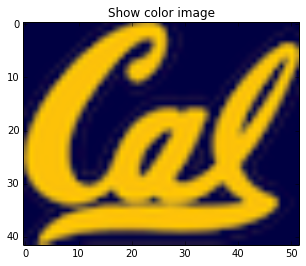

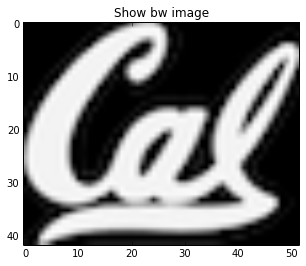

In [3]:
im = misc.imread('imgs/cal_ds.bmp') # load an image
plt.imshow(im)
plt.title('Show color image')

bw = rgb2gray(im) # convert to grayscale
plt.figure()
plt.title('Show bw image')
plt.imshow(bw, cmap='gray')

In [4]:
# Adding lab 5 part 2 shit

In [52]:
def int2bitarray(intarray, width=8):
    # converts an array of integers type uint8 and returns an equivalent Python bitarray.bitarray
    # use width = 1 if intarray contains 1, 0s
    # use width = 8 for 8 bit ints
    bits = ''
    for num in intarray:
        bits += np.binary_repr(num,width)
    bits = bitarray.bitarray(bits)
    return bits

def bits2nparray(bits):
     # converts {0,1}^n bitarray to np array
    return (np.fromstring((str(bits)[10:-2]),'u1') - ord('0')).astype(np.float)


def afsk1200(bits, fs = 48000.0):
    #
    # data encoded at a data-rate of 1200b/s
    #
    # m(t) has value has value = 1 for a duration of a mark (@1200Hz) bit, and -1 for the duration of a space (@2200Hz) bit.
    #
    #
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs.
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal

    bits = -2*bits2nparray(bits) + 1 # want -1, +1 bits
    bit_period = 1/1200
    fc = 1700
    df = 500
    temp_rate = lcm((1200,fs)) # first generate signal at a higher frequency than fs s.t. it is a multiple of 1200.
    repeat_bit = int(temp_rate*bit_period)
    bits = np.hstack([ [b]*repeat_bit for b in bits ]) # bitrate is 1200b/s, so make each bit last for 1/1200 s.
    
    integral = integrate.cumtrapz(fc + df*bits) # integral of constant dt = t*constant.
    sig = np.cos( 2*np.pi*integral/temp_rate )
    sig = sig[::int(temp_rate/fs)] #  downsample

    return sig


def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0, baud=1200.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    
    # TBW calcxn kept from before, since TBW = 2
    # TBW = (M+1)*(omega/2pi) = 2.
    # omega = (2pi/fs)*1200*2 = 0.3414 (remember, two-sided)
    # ==> 2 = TBW = (M+1)*0.3414/2pi
    # ==> M = ciel(35.81)-1 = 36-1 = 35

    # low pass filter 
    modulator = lambda freq, t: np.exp(-2j*pi*freq*t)

    taps = (int(fs/baud*TBW)//2)*2+1
    t = r_[0:taps]/fs

    # Denoise bandpass actually
    denoise_lp = signal.firwin(taps, cutoff=800/(2*fs))*modulator(1700, t) # fc at 1700, 900-2500 passb.
    sig = signal.fftconvolve(sig, denoise_lp, 'same')

    # Band pass mark and space
    
    lpf = signal.firwin(taps, cutoff=baud/(2*fs))

    # complex modulate to ctr around 1200 Hz and 2200 Hz
    
    bp1200 = lpf*modulator(1200, t)
    bp2200 = lpf*modulator(2200, t)

    mark_bits = signal.fftconvolve(sig, bp1200, 'same')
    space_bits = signal.fftconvolve(sig, bp2200, 'same')

    # here, abs(...) is envelope of (...). Difference of envelopes is NRZ; see figure 3.
    NRZ = abs(mark_bits) - abs(space_bits)

    # noise reduction: get rid of high-freq noise.

    noise_rdxn_lpf = signal.firwin(taps, cutoff=1.2*baud/fs)
    denoised_NRZ = signal.fftconvolve(NRZ, noise_rdxn_lpf, 'same')
    
    return denoised_NRZ


def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phase-locked loop for timing recovery
    # Inputs:
    #          NRZa -   The **ANALOG** NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baud  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    #    np.int32(2**31-1+1) useful
    # Your code here

    counter, increment = 0, 2**32/(fs/baud)
    
    idx = []
    for i in range(len(NRZa)-1):  
        
        if sign(np.int32(counter + increment))  == -1 and sign(np.int32(counter)) == 1: # counter overflow, so sample!
            idx += [i]
            
        if sign((NRZa[i])) == 1 and sign(NRZa[i+1]) == -1:
            counter = np.int32(counter*a)
            
        counter = np.int32(counter + increment)
        
    return np.array(idx)

def decode_NRZ(demoded_bits, fs=48e3, baud=1200.0):
    # decodes the output of nc_afsk1200Demod
    sign_NRZ = sign(demoded_bits)
    dig_NRZ = sign_NRZ[int((fs/baud)/2)::int(fs/baud)] # sample bits at the middle of the bit period
    bit_dec = bitarray.bitarray((dig_NRZ>0).tolist())
    return bit_dec


def BER(bits1,bits2):
    # Compares two bitstreams
    # BER = # of bit errors (received bits that have been altered due to decoding error) / total # of transmitted bits.
    assert len(bits1) == len(bits2), 'Lengths must be equal.'
    return np.sum(bits2nparray(bits1) != bits2nparray(bits2))/len(bits1)

In [6]:
# Adding lab 1 shit

In [7]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig

def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %

    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    xmw = x * hanning(m)[:,None];
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q,ctrlQ ,p, fs , dev, ser="", keydelay=0):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # ctrlQ - A queue object for ending the thread
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    #
    #
    # There are two ways to end the thread: 
    #    1 - send "EOT" through  the control queue. This is used to terminate the thread on demand
    #    2 - send "EOT" through the data queue. This is used to terminate the thread when data is done. 
    #
    # You can also key the radio either through the data queu and the control queue
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        if not ctrlQ.empty():
            
            # control queue 
            ctrlmd = ctrlQ.get()
            if ctrlmd is "EOT"  :
                    ostream.stop_stream()
                    ostream.close()
                    print("Closed  play thread")
                    return;
            elif (ctrlmd is "KEYOFF"  and ser!=""):
                ser.setDTR(0)
                #print("keyoff\n")
            elif (ctrlmd is "KEYON" and ser!=""):
                ser.setDTR(1)  # key PTT
                #print("keyon\n")
                time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
                
        data = Q.get()
        
        if (data is "EOT") :
            ostream.stop_stream()
            ostream.close()
            print("Closed  play thread")
            return;
        elif (data is "KEYOFF"  and ser!=""):
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data is "KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue,ctrlQ, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        if not ctrlQ.empty():
            ctrlmd = ctrlQ.get()          
            if ctrlmd is "EOT"  :
                istream.stop_stream()
                istream.close()
                print("Closed  record thread")
                return;
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        
def play( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 AirPlay
1 Built-in Microph
2 Built-in Output
3 USB PnP Sound Device


In [8]:
# import skimage

In [9]:
# Set device numbers
daudio_in = 1
daudio_out = 2
dusb_in = 3
dusb_out = 3

# Get sampling rate of radio
p = pyaudio.PyAudio()
fs_usb = p.get_device_info_by_index(dusb_out)['defaultSampleRate']
p.terminate()

In [10]:
# Run this line once. No need to run repeatedly. Comment it out after running successfully.
s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
# DO IT

In [11]:
# Figure out dumb radio/offset crap
# Sanity check: run this once to make sure everything's ok

s.setDTR(0)

# Setup SDR
fs_sdr = 240000
fc =    144.665e6 # set center frequency
ppm =   26        # set estimate ppm
gain =  26        # set gain

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)

# start transmitting
s.setDTR(1)
y = sdr.read_samples(256000*6)

# stop transmitting
s.setDTR(0)
sdr.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('Offset:', 0.0)
shift in Hz: 0.0
shift in ppm: 0.0


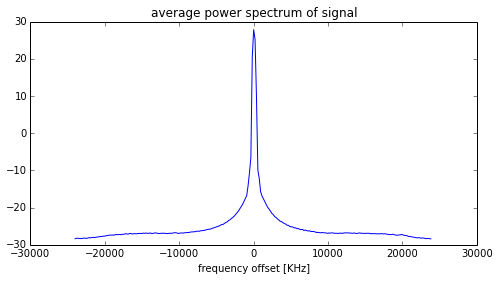

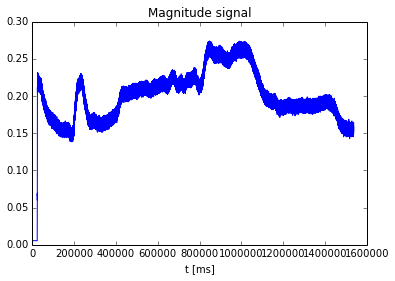

In [12]:
# Plot magnitude signal and compute frequency offset

f, sp = avgPS(y,N=256,fs=fs_usb)
fig = figure(figsize=(8,4))
plot(f,10*log10(sp))
title('average power spectrum of signal')
xlabel('frequency offset [KHz]')
offset = f[np.argmax(10*log(sp))]
print('Offset:', offset)

# plot 
fig = figure(figsize=(16,4))
figure()
plot(abs(y))
title('Magnitude signal')
xlabel('t [ms]')

f0 = offset = f[np.argmax(10*log(sp))]
ppmcalib = offset * 1e6  / fc

print 'shift in Hz:', f0
print 'shift in ppm:',ppmcalib

In [13]:
# test radio
s.setDTR(0)

for n in range(0,10):
    s.setDTR(1)
    time.sleep(0.25)
    s.setDTR(0)
    time.sleep(0.25)
    
print('if this prints, you\'re good!')

if this prints, you're good!


In [14]:
# goal: AFSK modulate array, transmit, and decode.

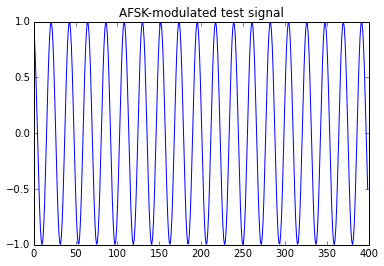

In [15]:
# Build test signal

# Notes:
# Data sent to the radio is at fs = fs_usb 
# Data received by the SDR antenna is at fs = fs_sdr
# Sound is played through speakers at fs = 48KHz

# Create array of bits
to_send = hstack([zeros(500),ones(500),zeros(500),ones(1000),zeros(100),ones(1000),zeros(500)])
transmitted_bits = int2bitarray(to_send, width=1)

# AFSK1200 Modulate
sig_test = afsk1200(transmitted_bits, fs=fs_usb)

figure()
title('AFSK-modulated test signal')
plot(sig_test[:400])

In [16]:
# # Play AFSK1200-modulated signal

# p2 = pyaudio.PyAudio()
# print('Signal length', len(sig_test)/48000, 'seconds')
# play(sig_test, p2, 48000)
# p2.terminate()

In [17]:
p = pyaudio.PyAudio()

# Make a new radio and reload settings from above

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.set_freq_correction(ppm)

Q = Queue.Queue()
cQ = Queue.Queue()

s.setDTR(0)

# Transmit and receive signal

Q.put(zeros(fs_usb/2)) # wait 1/2 second

Q.put('KEYON')          # start transmitting
Q.put(sig_test)         # start playing audio
Q.put(zeros(fs_usb/2))  # wait 1/2 second
Q.put('KEYOFF')
Q.put('EOT')

t_play = threading.Thread(target = play_audio,   args = (Q, cQ,  p, 44100, dusb_out ,s ))

s.setDTR(1)
t_play.start()

recvd_sig = sdr.read_samples(256000*4)
sdr.close()
s.setDTR(0)

while not(Q.empty()) :
    time.sleep(1)
    
p.terminate()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Closed  play thread


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


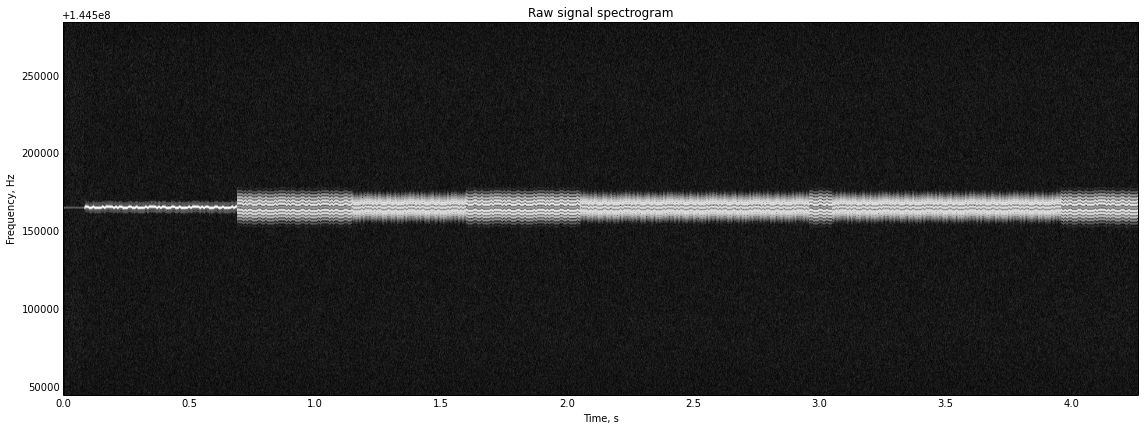

In [18]:
myspectrogram_hann_ovlp(recvd_sig, 512, fs_sdr, fc, dbf=60);
title('Raw signal spectrogram')

In [19]:
# FM Demodulation
hdiff = lambda s: signal.fftconvolve(s,
                                    signal.remez(31, [0.0,10000.0,12000.0,12000.0],[1.05/1.2,0], Hz = 24e3, type='differentiator'),
                                    mode='same')

demod = lambda s: np.imag(np.conj(s)*hdiff(s))


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


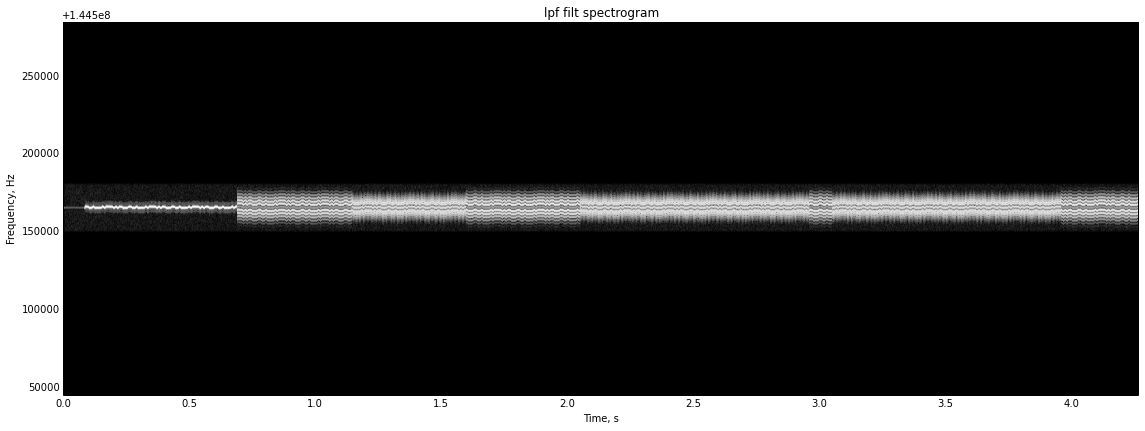

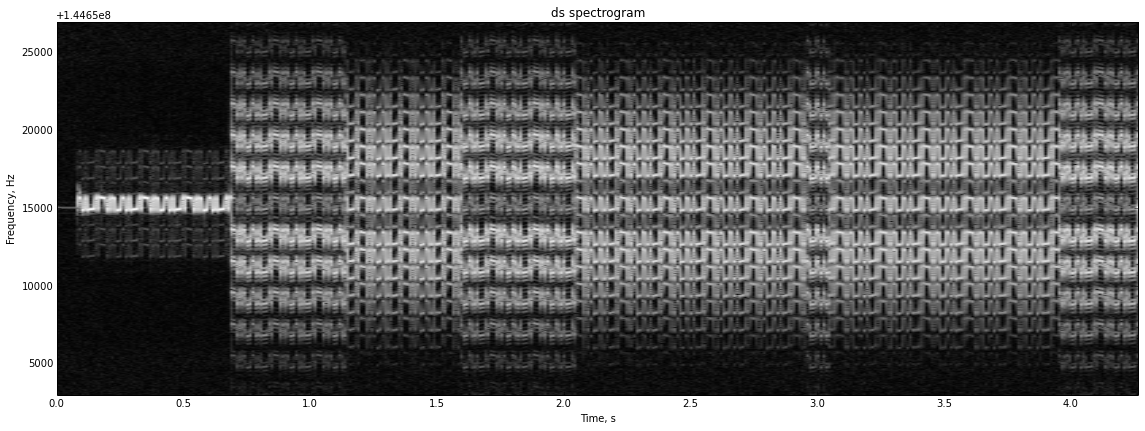

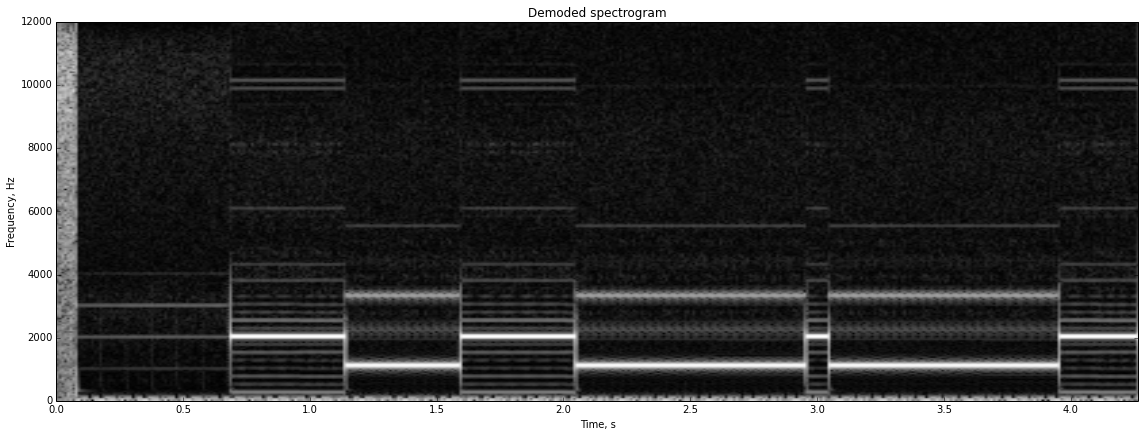

In [23]:
# Decode received data

# LPF received
lpf = signal.firwin(513, cutoff=15e3/120e3)
filt_recvd = signal.fftconvolve(recvd_sig, lpf, 'same')

myspectrogram_hann_ovlp(filt_recvd, 512, fs_sdr, fc, dbf=60);
title('lpf filt spectrogram')

ds = 10 # downsample factor
ds_data = filt_recvd[::ds]

myspectrogram_hann_ovlp(ds_data, 512, fs_sdr/ds, fc, dbf=60);
title('ds spectrogram')

demoded = demod(ds_data/np.abs(ds_data))

myspectrogram_hann_ovlp(demoded, 512, fs_sdr/ds, 0, dbf=60);
title('Demoded spectrogram')

# Is this necessary?
# Demodulation
# freq = 2200
# t = np.linspace(0,513/(fs_sdr/10),513)
# modulator = np.exp(2j*pi*freq*t)
# ssb_filter = np.hanning(513)*modulator
# ssb_filt_recvd = signal.fftconvolve(demoded, ssb_filter, 'same')

# myspectrogram_hann_ovlp(ssb_filt_recvd, 512, fs_sdr/ds, 0, dbf=60);
# title('ssb filt of demoded, spectrogram')

1


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


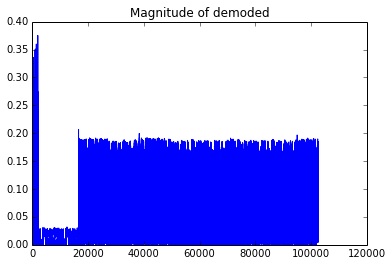

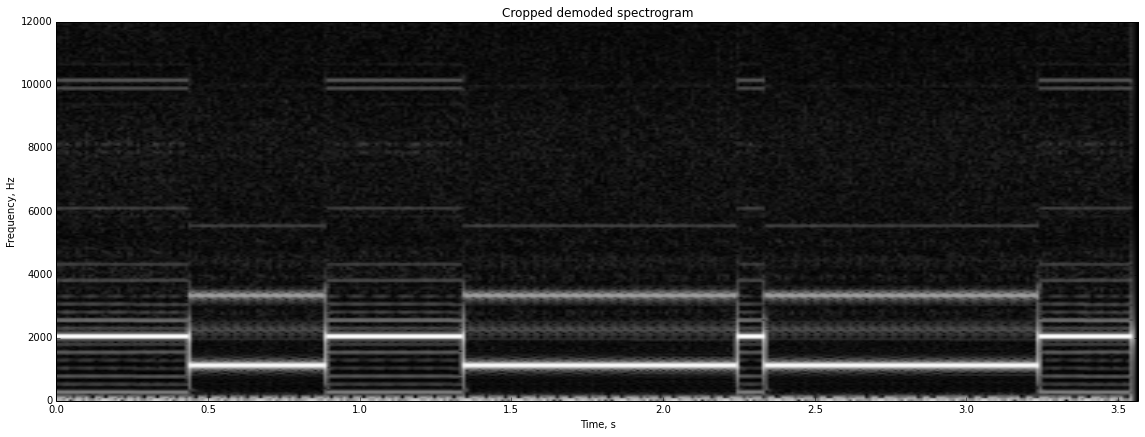

In [72]:
plot(abs(demoded))
title('Magnitude of demoded')

estimate_start_t = 0.7 # in seconds
estimate_end_t = 4.0

est_start_ind = int((estimate_start_t / (len(demoded)/(fs_sdr/ds))) * len(demoded))
est_end_ind = int((estimate_end_t / (len(demoded)/(fs_sdr/ds))) * len(demoded))

est_signal = demoded[est_start_ind:]
# est_signal = demoded[est_start_ind:est_end_ind]

myspectrogram_hann_ovlp(est_signal, 512, fs_sdr/ds, 0, dbf=60);
title('Cropped demoded spectrogram')

In [80]:
# Demodulate received filtered signal
afsk_demod_recvd = nc_afsk1200Demod(est_signal, fs=fs_sdr/ds, TBW=2.0) # analog output, that is, it's not just 1s/0s, but almost.

# Calculate NRZ and then convert to 1s and 0s
bits_dec = decode_NRZ(afsk_demod_recvd)

# Print decoded bits, compare to the transmitted bits
print(bits_dec[0:4])
print(transmitted_bits[0:4])
# ber = BER(bits_dec, transmitted_bits)
# print('Percent error in transmission:', 100*ber, '%')

bitarray('0000')
bitarray('0000')


In [78]:
print(len(bits_dec), len(transmitted_bits))

(2140, 4100)


In [79]:
bits_dec

bitarray('111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [76]:
transmitted_bits

bitarray('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111